# i4talent assessment opdracht
i4talent begon ooit als detacheerder van finance professionals en later ook van data analisten.

Nu we een data science consultancy unit hebben, heeft de detachering unit ons gevraagd of wij ze kunnen helpen met een volgende probleem: de (te hoge) uitstroom van professionals. Dit zijn
professionals die zelf weggaan, ontslagen worden of met pensioen gaan. i4talent wil graag de uitstroom minimaliseren.

In deze opdracht kijken we of de de data van i4talent kunnen gebruiken om de uitstroom te voorspellen en mogelijk te minimaliseren.


### Import libraries
We starten met het importeren van een aantal libraries die we nodig zullen hebben voor deze opdracht.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

### Data laden

In [3]:
# Defining data for the dataframe
data = pd.read_csv('i4talent.csv')
data.columns = map(str.lower, data.columns)

### Data opschonen
Laten we eerst kijken naar of er ontbrekende data aanwezig is en een nieuwe binaire kolom toe te voegen voor werkstatus. Deze kolom noemen we 'gestopt' dat een 1 is wanneer de medewerker is gestopt, en 0 wanneer zij nog werkzaam zijn.

In [4]:
data["gestopt"] = data["status"].apply(lambda x : 1 if x=="Beëindigd" else 0)
# Sorteer de DataFrame op 'werknemerid' en 'status_jaar'
data_sorted = data.sort_values(by=['werknemerid', 'status_jaar'], ascending=[True, False])

# Drop duplicates, om alleen de meest recente werknemerid te krijgen
data_unique = data_sorted.drop_duplicates(subset='werknemerid', keep='first')
data_unique = data_unique.reset_index(drop=True)

data_unique["datum"] = pd.to_datetime(data_unique["datum"])
data_unique["geboortedatum"] = pd.to_datetime(data_unique["geboortedatum"])
data_unique["indiensttreding_datum"] = pd.to_datetime(data_unique["indiensttreding_datum"])
data_unique['uitdiensttreding_datum'] = pd.to_datetime(data_unique['uitdiensttreding_datum'])

# Bepaal welke kolommen missende data bevatten.
print(data_unique.columns[data_unique.isna().any()].tolist())

['leeftijd', 'lengte_dienst', 'stad', 'afdeling']


De volgende kolommen missen data: Leeftijd, lengte_dienst, stad, afdeling. Hiervoor nemen we de volgende stappen:

- Leeftijd: Als we een leeftijd missen, maar wel een geboortedatum hebben, kunnen we deze herleiden met de geboortedatum en statusjaar. De geboortedatum ronden we af op het jaar.

- Lengte_dienst: De dienstlengte kunnen we herleiden vanuit de indiensttreding datum en statusjaar op eenzelfde wijze.

- Voor de stad en afdeling vullen we 'onbekend' in. Alternatieve keuze is om te kijken of van deze persoon er al een bekende afdeling is. Op dit moment heb ik nog geen sterk vermoeden om te denken dat dit veel effect zal hebben en ga ik voor het gemak uit dat 'onbekend' voldoende werkt.

In [5]:
missende_leeftijden = np.where(data_unique["leeftijd"].isna())[0]
geboortedatum = data_unique["geboortedatum"]
geboortejaar = np.where(
    (geboortedatum.dt.month < 7), geboortedatum.dt.year,geboortedatum.dt.year + 1)
leeftijd = data_unique["status_jaar"] - geboortejaar
data_unique.loc[missende_leeftijden, 'leeftijd'] = leeftijd

missende_dienstjaar = np.where(data_unique["lengte_dienst"].isna())[0]
indiensttreding_datum = data_unique["indiensttreding_datum"]
indiensttrading_jaar = np.where(
    (indiensttreding_datum.dt.month < 7), indiensttreding_datum.dt.year,indiensttreding_datum.dt.year + 1)
lengte_dienst = data_unique["status_jaar"] - indiensttrading_jaar
data_unique.loc[missende_dienstjaar, 'lengte_dienst'] = lengte_dienst

missende_stad = np.where(data_unique["stad"].isna())[0]
data_unique.loc[missende_stad, 'stad'] = 'Onbekend'

missende_afdeling = np.where(data_unique["afdeling"].isna())[0]
data_unique.loc[missende_afdeling, 'afdeling'] = 'Onbekend'

### Exploratory data analysis: KDE
Ik ben benieuwd hoe de data tussen gestopte medewerkers eruit ziet tov medewerkers die nog werken. Hiervoor splits ik de data en plot ik kansdichtheidsfuncties om inzicht te krijgen in hoe de data zich verdeeld.

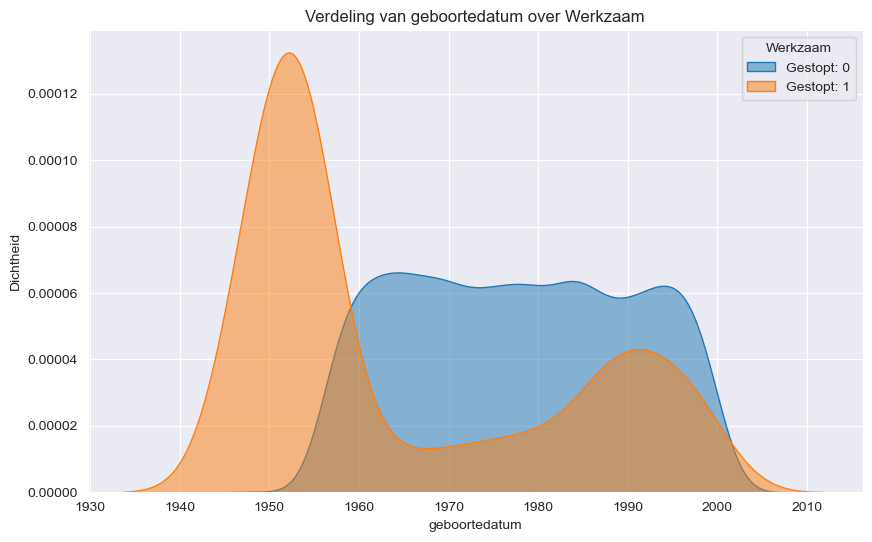

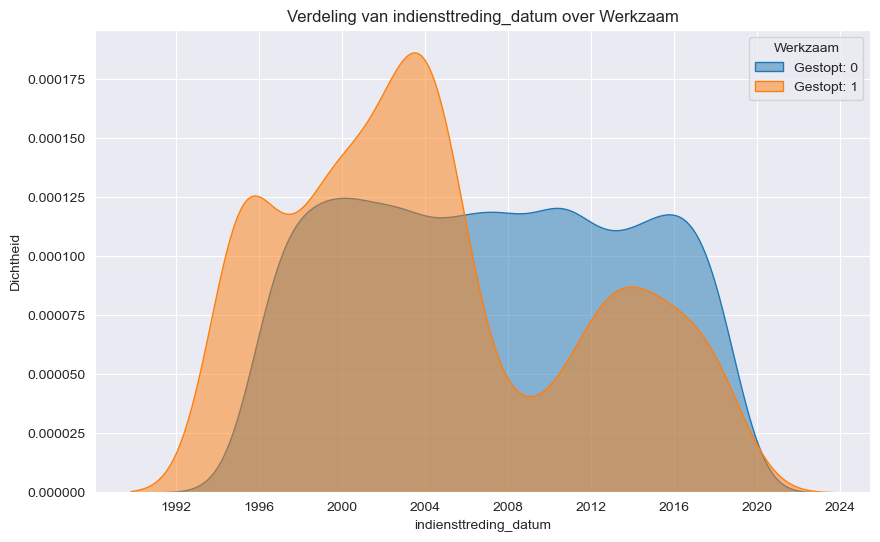

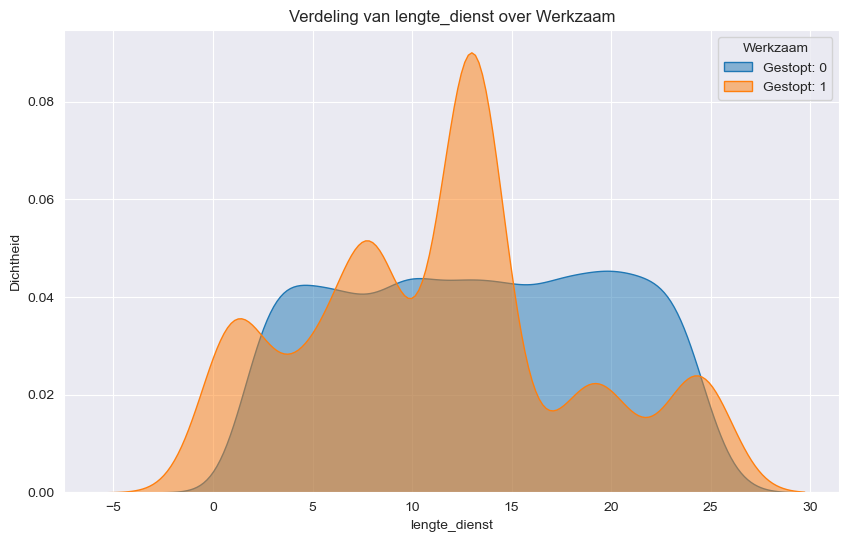

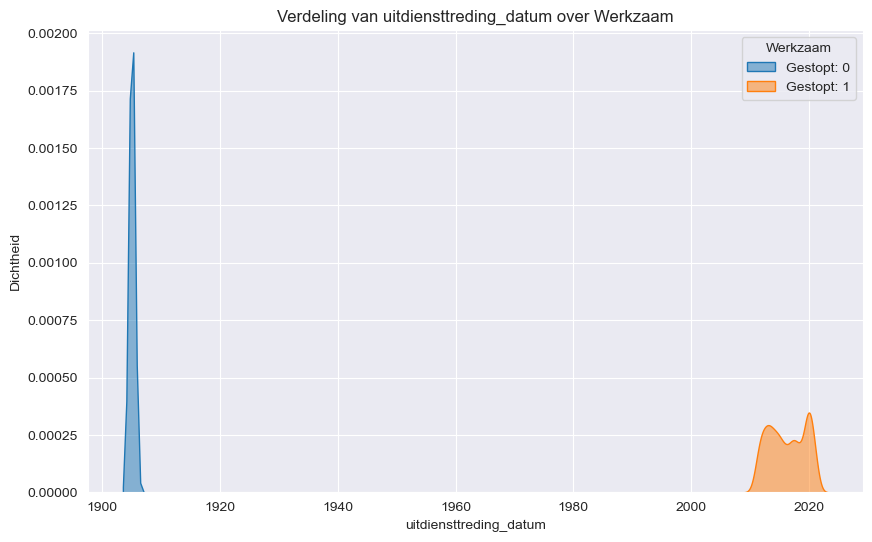

In [6]:
columns = ["geboortedatum", "indiensttreding_datum", "lengte_dienst", "uitdiensttreding_datum"]
data_selected = data_unique[columns + ["gestopt"]]  # Ensure 'werkzaam' is included

for column in columns:
    plt.figure(figsize=(10, 6))

    # Plot KDE voor elke categorie in 'werkzaam'
    for werkzaam_category in data_selected['gestopt'].unique():
        sns.kdeplot(
            data=data_selected[data_selected['gestopt'] == werkzaam_category],
            x=column,
            label=f"Gestopt: {werkzaam_category}",
            fill=True,  # Optional: fills the area under the curve
            alpha=0.5  # Adjust transparency        
        )
        plt.title(f'Verdeling van {column} over Werkzaam')
    plt.xlabel(column)
    plt.ylabel('Dichtheid')

    # Explicitly display the legend
    plt.legend(title='Werkzaam')
    plt.show()

### Exploratory data analaysis: Tijd trends
Ook is er de vraag of er trends aanwezig zijn: Stoppen mensen regelmatig in een specifieke maand waar we rekening mee moeten houden?

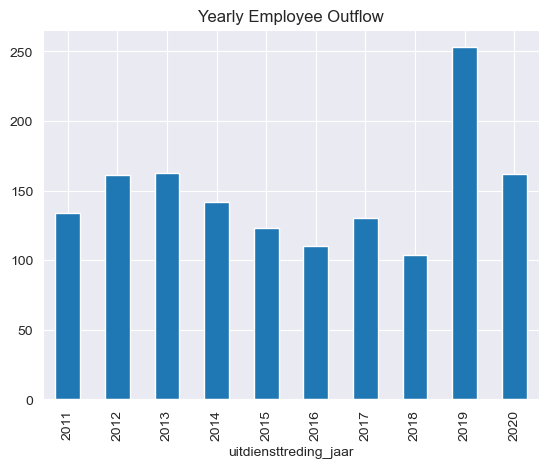

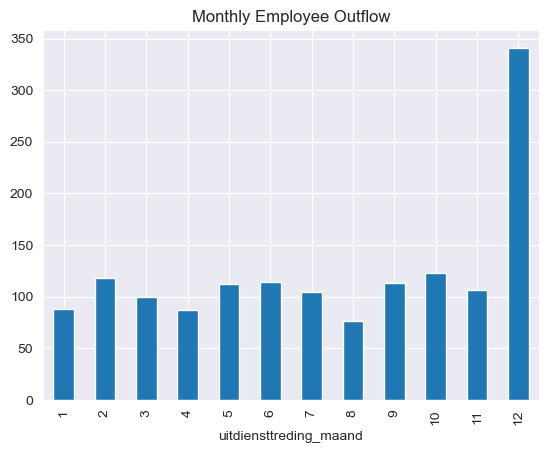

In [7]:
data_unique['uitdiensttreding_jaar'] = data_unique['uitdiensttreding_datum'].dt.year
data_unique['uitdiensttreding_maand'] = data_unique['uitdiensttreding_datum'].dt.month

yearly_outflow = data_unique[data_unique['uitdiensttreding_jaar'] > 1905].groupby('uitdiensttreding_jaar')['gestopt'].sum()
monthly_outflow = data_unique.groupby('uitdiensttreding_maand')['gestopt'].sum()

yearly_outflow.plot(kind='bar', title='Yearly Employee Outflow')
plt.show()

monthly_outflow.plot(kind='bar', title='Monthly Employee Outflow')
plt.show()

### Exploratory data analaysis: Tijd trends 2
Er gebeurt iets interessants in december en in 2019. Er lijken bijzonder veel mensen gestopt te zijn in deze maand/jaar. Wellicht dat de reden van ontslag hier meer inzicht in kan geven.

In [8]:
data_unique['uitdiensttreding_datum'] = pd.to_datetime(data_unique['uitdiensttreding_datum'])
data_2019 = data_unique[
    data_unique['uitdiensttreding_datum'].dt.year == 2019
    ]

# Tel de redenen voor stoppen in 2019
reasons_2019 = data_2019['uitdiensttreding_reden'].value_counts()
total_2019 = len(data_2019)


# Output
print(f"Totaal aantal mensen die in 2019 weg gingen: {total_2019}")
print("\nRedenen:")
print(reasons_2019)


december_data = data_unique[
    data_unique['uitdiensttreding_datum'].dt.month == 12
    ]

# Tel de redenen voor stoppen in december
december_reasons = december_data['uitdiensttreding_reden'].value_counts()
total_december = len(december_data)


# Output 
print(f"\nTotaal aantal mensen die in december weg gingen: {total_december}")
print("\nRedenen:")
print(december_reasons)

# Tel alle redenen waarom mensen stoppen
data_filtered = data_unique[data_unique['uitdiensttreding_jaar'] > 1905]
reason_counts = data_filtered['uitdiensttreding_reden'].value_counts()

# Tel hoevaak mensen ontslagen zijn
fired_count = reason_counts.get('Ontslag', 0)  # Replace 'Fired' with the exact label in your dataset

# Proporite van ontslaagde mensen
total_leavers = len(data_filtered)
fired_proportion = fired_count / total_leavers if total_leavers > 0 else 0

# Output the results
print(f"\nTotaal aantal mensen die weg gingen: {total_leavers}")
print(f"Aantal ontslagingen: {fired_count}")
print("\nRedenen voor vertrek:")
print(reason_counts)

Totaal aantal mensen die in 2019 weg gingen: 253

Redenen:
uitdiensttreding_reden
Ontslag     142
Pensioen     56
Vertrek      55
Name: count, dtype: int64

Totaal aantal mensen die in december weg gingen: 344

Redenen:
uitdiensttreding_reden
Ontslag                215
Pensioen                91
Vertrek                 35
Niet van toepassing      3
Name: count, dtype: int64

Totaal aantal mensen die weg gingen: 1485
Aantal ontslagingen: 215

Redenen voor vertrek:
uitdiensttreding_reden
Pensioen               883
Vertrek                384
Ontslag                215
Niet van toepassing      3
Name: count, dtype: int64


### Exploratory data analysis: Tijd trends 3
Het lijkt erop dat de pieken in december en 2019 te maken hebben met ontslag. Alle ontslagingen zijn in december doorgevoerd en vooral in 2019. Dit verklaart het gedrag in het vertrek dat we zien.

Om verder inzicht te krijgen in het vertrekkend personeel, wil ik specifiek kijken naar de groep die het meest onverwacht is, oftewel, de mensen die vertrekken zonder ontslag of pensioen.

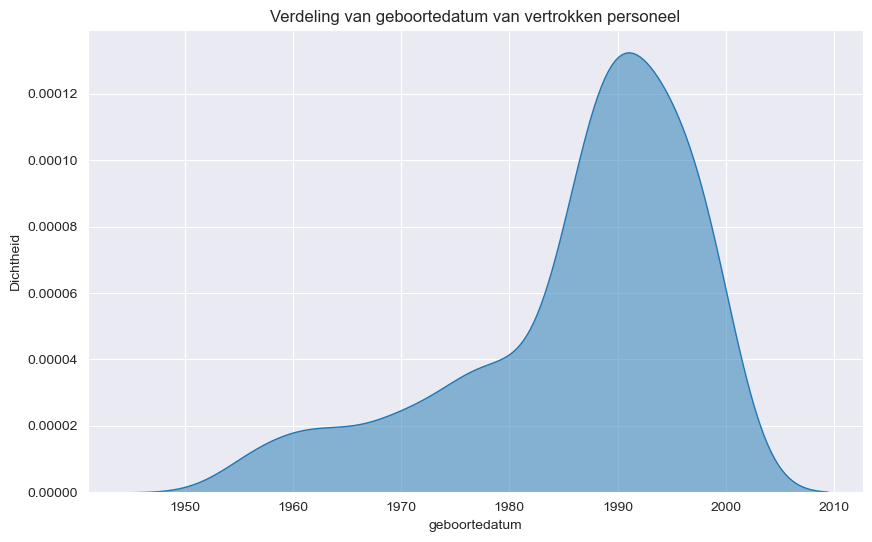

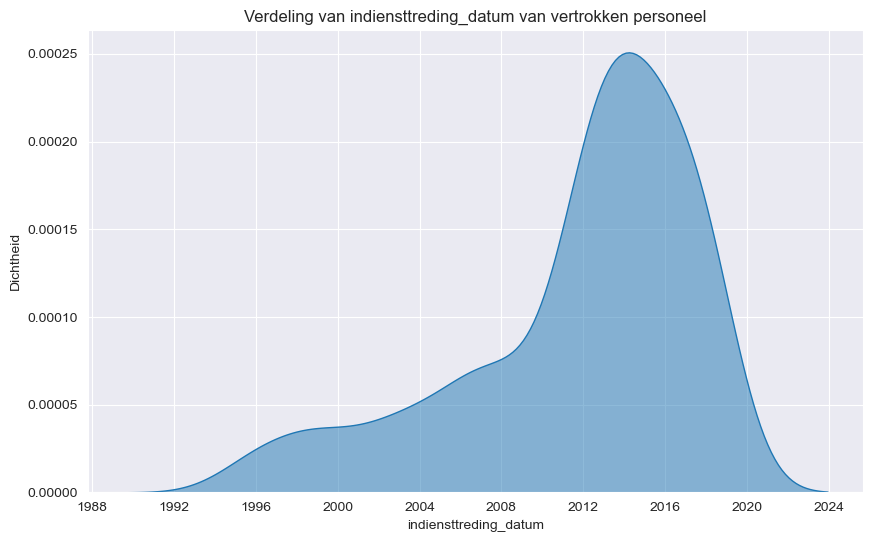

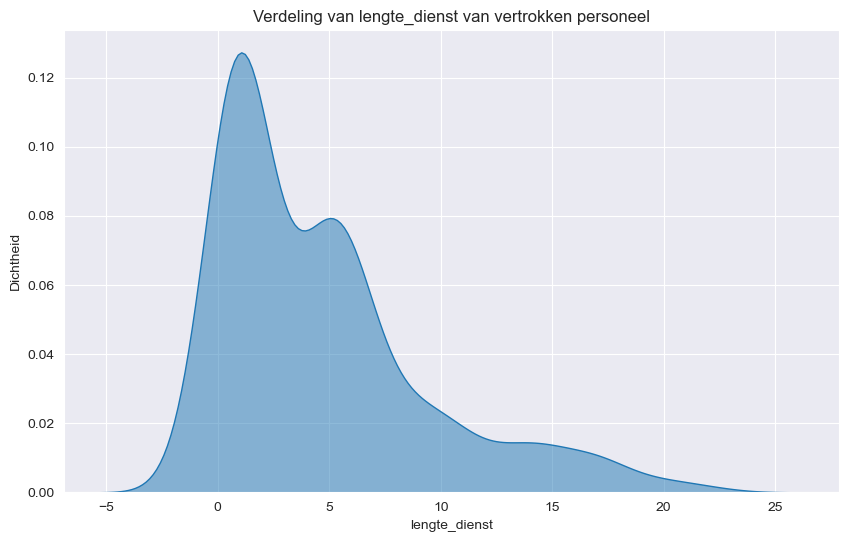

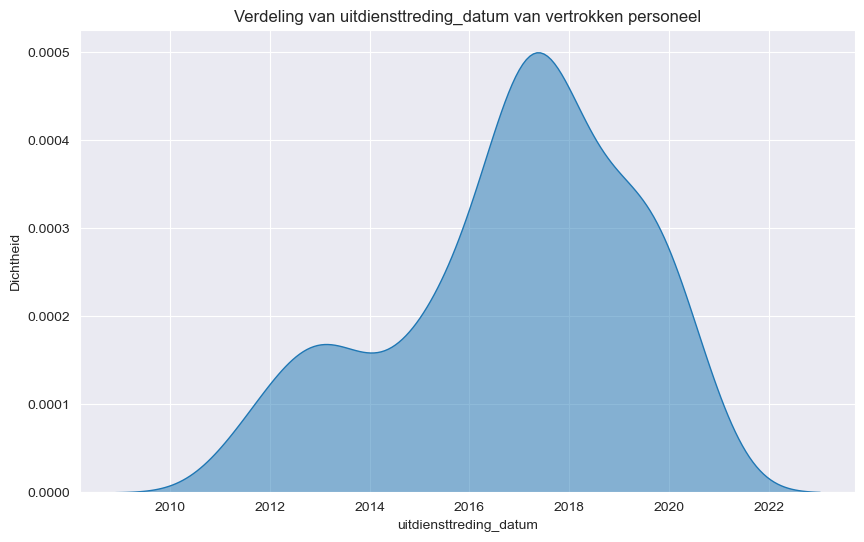

In [9]:
data_vertrek = data_unique[data_unique['uitdiensttreding_reden'] == 'Vertrek']
columns = ["geboortedatum", "indiensttreding_datum", "lengte_dienst", "uitdiensttreding_datum"]

# Iterate over selected columns, excluding 'werkzaam'
for column in columns:
    plt.figure(figsize=(10, 6))

    # Plot KDE for each category in 'werkzaam'

    sns.kdeplot(
        data=data_vertrek,
        x=column,
        fill=True,  # Optional: fills the area under the curve
        alpha=0.5  # Adjust transparency        
    )
    plt.title(f'Verdeling van {column} van vertrokken personeel')
    plt.xlabel(column)
    plt.ylabel('Dichtheid')

    # Explicitly display the legend
    plt.show()

Wat we zien in deze groep, is dat de mensen die vertrekken vooral binnen een jaar tot 5 jaar weg gaan. Dit is vooral een jonge groep (geboortedatum > 1990). Na vijf jaar, lijken de medewerkers snel lang te blijven binnen het bedrijf. 

### Exploratory data analysis: De correlaties van vertrekkers 
Om een beter inzicht te krijgen in welke factoren bepalend zijn voor vertrekkers, kunnen we kijken naar de correlatiematrix. Deze matrix geeft de correlaties weer tussen verschillende factoren. In het bijzonder zijn we geïnteresseerd hoe de werkzaamheidstatus gerelateerd is aan de andere factoren in de dataset. Hiervoor zullen we twee verschillende correlatiesmatrices maken: één voor de gehele populatie en één voor de vertrekkers. Hiermee willen we kijken of er verschil zit tussen wat bepalend is voor iemands vertrek tussen deze twee groepen.

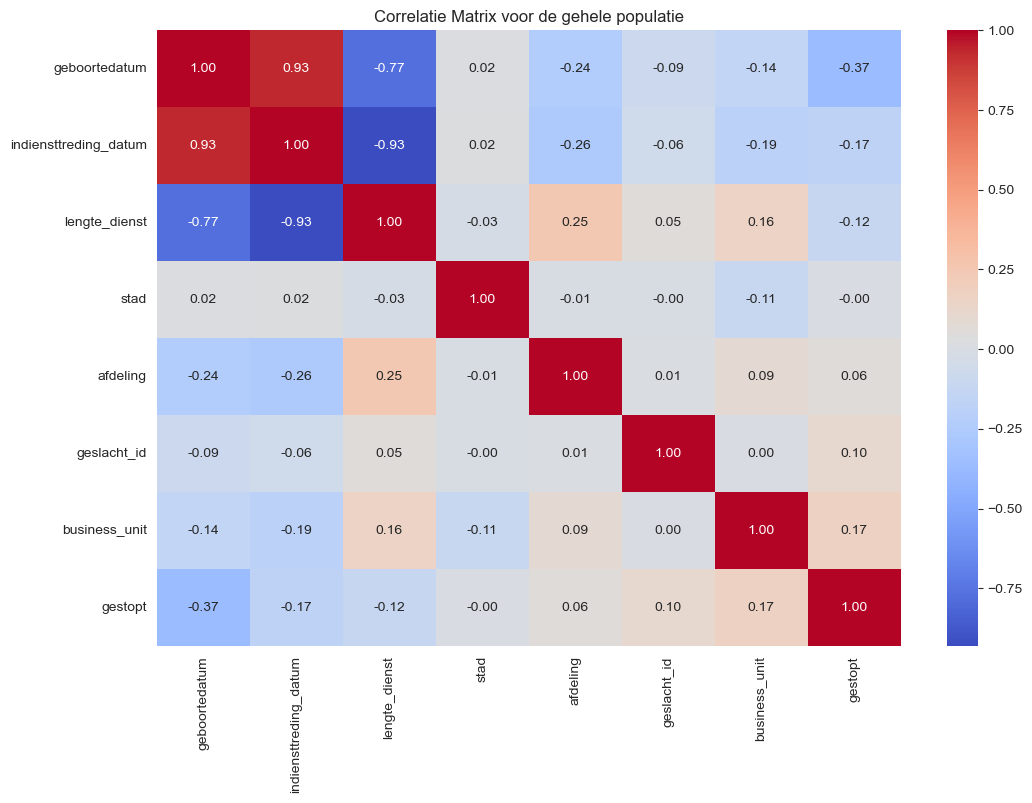

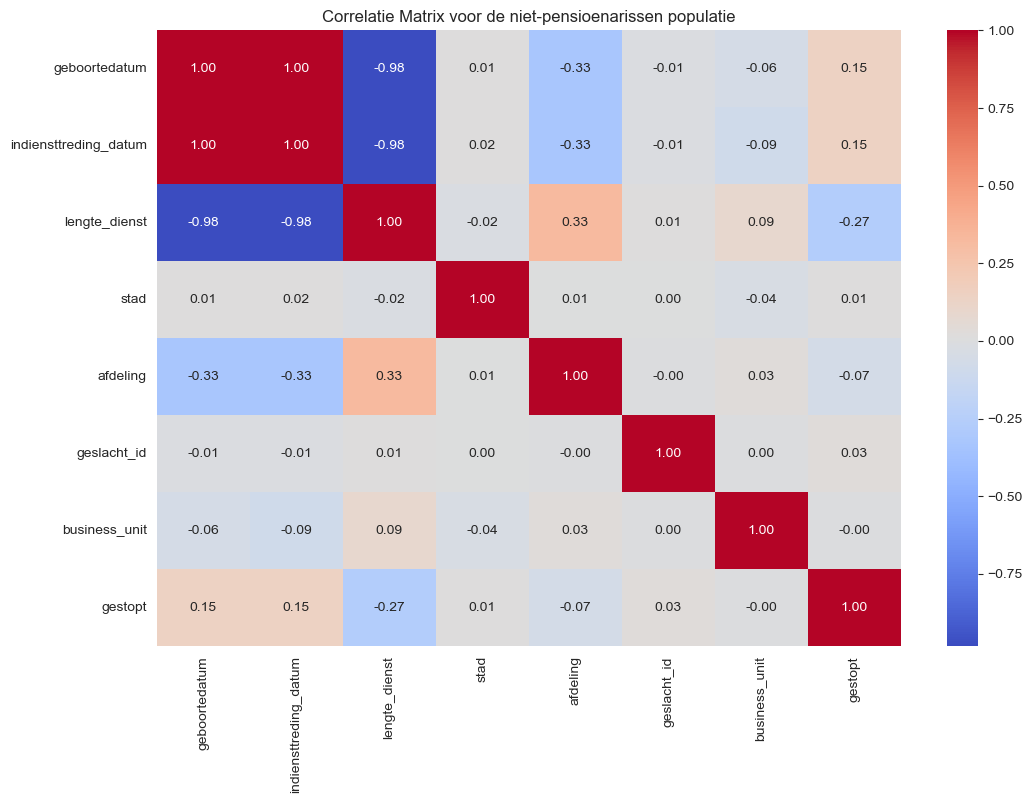

In [10]:
# List van categorische kolommen die encode moeten worden
categorical_columns = [
    "stad", "afdeling", "geslacht_id", "business_unit", "gestopt"
]

columns = ["geboortedatum", "indiensttreding_datum", "lengte_dienst", "stad", "afdeling", "geslacht_id", "business_unit", "gestopt"]
data_filtered = data_unique[columns]

# Creëer kopie om te voorkomen data we data_filtered aanpassen (en om de warnings tegen te gaan)
data_encoded = data_filtered.copy()

label_encoder = LabelEncoder()

# Encode elke categorische kolom
for column in categorical_columns:
    data_encoded[column] = label_encoder.fit_transform(data_encoded[column].astype(str))

# Correlations
correlation_matrix = data_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlatie Matrix voor de gehele populatie")
plt.show()

data_filtered = data_unique[data_unique["uitdiensttreding_reden"] != 'Pensioen']
data_filtered = data_filtered[columns]

# Repeat voor iedereen die niet door pensioen gestopt is
data_encoded = data_filtered.copy()

label_encoder = LabelEncoder()

for column in categorical_columns:
    data_encoded[column] = label_encoder.fit_transform(data_encoded[column].astype(str))

correlation_matrix = data_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlatie Matrix voor de niet-pensioenarissen populatie")
plt.show()

### Model training
In deze correlatiematrices zien we dat of iemand gestopt is gecorreleerd is aan de features van de data. Hieruit lijkt op eerst oogopslag dat geboortedatum, datum van indiensttreding, lengte dienst en (zwak, maar aanwezig) business unit en afdeling. Echter is er onderling de verschillende kolommen ook correlaties aanwezig. Om een goede minimum set aan benodigde parameters te hebben, zal ik daarom ook kijken naar het belang van de features middels een random forest. Het voordeel van een random forest t.o.v. de klassieke correlatie coefficient is dat het random forests ook non-lineaire interacties in kaart brengt.

In [11]:
data_processed = data_filtered.copy()

# Convert date columns naar Unix timestamps voor RF
data_processed['geboortedatum_unix'] = pd.to_datetime(data_processed['geboortedatum']).astype('int64') / 10**9
data_processed['indiensttreding_unix'] = pd.to_datetime(data_processed['indiensttreding_datum']).astype('int64') / 10**9

# Encode categorical columns
categorical_columns = ['afdeling', 'business_unit']  # Voeg eventuele extra features toe
label_encoder = LabelEncoder()
for column in categorical_columns:
    data_processed[column] = label_encoder.fit_transform(data_processed[column].astype(str))

# Kies features en target
X_all = data_processed[['geboortedatum_unix', 'lengte_dienst']]  # Add relevant features
y_all = data_processed['gestopt']

# Fit de Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_all, y_all)

# Get feature importances
feature_importances = model.feature_importances_
print("Belang van features in de totale gestopte populatie:")
# Display feature importances
for feature, importance in zip(X_all.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")
    
data_filtered = data_unique[data_unique["uitdiensttreding_reden"] != 'Pensioen']
data_filtered = data_filtered[columns]

data_processed = data_filtered.copy()

# Repeat voor niet gepensioeneerde vertrekkers
data_processed['geboortedatum_unix'] = pd.to_datetime(data_processed['geboortedatum']).astype('int64') / 10**9
data_processed['indiensttreding_unix'] = pd.to_datetime(data_processed['indiensttreding_datum']).astype('int64') / 10**9

# Encode categorical columns
categorical_columns = ['afdeling', 'business_unit']  # Voeg eventuele extra features toe
label_encoder = LabelEncoder()
for column in categorical_columns:
    data_processed[column] = label_encoder.fit_transform(data_processed[column].astype(str))

# Select features and target
X_geen_pensioen = data_processed[['geboortedatum_unix', 'lengte_dienst', 'afdeling', 'business_unit']]  # Add relevant features
y_geen_pensioen = data_processed['gestopt']

# Fit the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_geen_pensioen, y_geen_pensioen)

# Get feature importances
feature_importances = model.feature_importances_

# Display feature importances
print("\nBelang van features in de gestopte populatie die niet met pensioen is gegaan:")
for feature, importance in zip(X_geen_pensioen.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Belang van features in de totale gestopte populatie:
Feature: geboortedatum_unix, Importance: 0.5699
Feature: lengte_dienst, Importance: 0.4301

Belang van features in de gestopte populatie die niet met pensioen is gegaan:
Feature: geboortedatum_unix, Importance: 0.5087
Feature: lengte_dienst, Importance: 0.4489
Feature: afdeling, Importance: 0.0420
Feature: business_unit, Importance: 0.0004


Enkel alleen de geboortedatum en lengte  van dienst bevatten 95% van het de belangrijke model features. Om te bevestigen dat deze twee parameters voldoende zijn om goede voorspellingen te maken, wil ik weten hoe goed de random forest zou zijn in het voorspellen van iemands werkstatus (gestopt of werkzaam) middels de geboortedatum en lengte dienst. Om zeker te zijn dat het model op zijn best presteert, zal ik ook hyperparameter tuning toepassen.

In [12]:
X_all = data_processed[['geboortedatum_unix', 'lengte_dienst']] 
y_all = data_processed['gestopt']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
# Initialize models
rf_model = RandomForestClassifier(random_state=42)

# Train Random Forest
rf_model.fit(X_train, y_train)

# Evaluate Random Forest
rf_preds = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]  # For ROC-AUC
print("Random Forest Results:")
print(classification_report(y_test, rf_preds))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_proba))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1453
           1       0.76      0.75      0.76       168

    accuracy                           0.95      1621
   macro avg       0.87      0.86      0.86      1621
weighted avg       0.95      0.95      0.95      1621

Random Forest ROC-AUC: 0.9256956051519024


In [13]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions on the test set
rf_preds = best_rf_model.predict(X_test)
rf_proba = best_rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, rf_preds))

print("ROC-AUC Score:", roc_auc_score(y_test, rf_proba))
joblib.dump(best_rf_model, 'tuned_random_forest_all.pkl')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1453
           1       0.91      0.73      0.81       168

    accuracy                           0.96      1621
   macro avg       0.94      0.86      0.90      1621
weighted avg       0.96      0.96      0.96      1621

ROC-AUC Score: 0.9381697964801887


['tuned_random_forest_all.pkl']

### Model kwaliteit
We zien dat zonder hyperparameter tuning het model goed presteert met een AUC van 0.93. Na hyperparameter tuning presteert de random forest model nauwlijks beter over de gehele populatie, maar is de F1-score van de mensen die stoppen wel iets hoger. Gezien het belang dat we de stoppende mensen goed identificeren, is dit naar mijn inziens een belangrijk genoeg verschil dat hyperparameter tuning een belangrijke stap is.

### Survival model
Het alleen identificeren van of iemand gestopt is, is geen volledige oplossing voor de opdracht. Hiervoor willen we ook in de toekomst kunnen voorspellen hoeveel mensen zullen stoppen. Hiervoor kunnen we een survival model maken, die gebaseerd is op de random forest model van hierboven. Allereerst maken we een nieuwe pd voor de survival data. De tijd datum hoeft nu niet meer in unix, maar kan gewoon als date time blijven. We moeten opnieuw

In [82]:
data_surv = data_unique.copy()
data_surv.loc[data_surv["lengte_dienst"] == -1, "lengte_dienst"] = 0

Random forest model met als event of iemand stopt, de duration lengte dienst en daarnaast de geboortedatum als extra relevant feature. De parameters in RandomSurvivalForest zijn de parameters uit de hyperparameter tuning.

In [83]:
y = pd.DataFrame({
    'event': data_surv['gestopt'],  # Event: whether they quit or not
    'duration': data_surv['lengte_dienst']  # Duration: how long they've been working
})
y = Surv.from_dataframe('event', 'duration', y)

# Prepare features
X = data_surv[['lengte_dienst', 'leeftijd']]  # Add other relevant features

# Train Random Survival Forest
rsf = RandomSurvivalForest(bootstrap = True, max_depth = 20, min_samples_leaf = 2, min_samples_split = 5, n_estimators = 300)
rsf.fit(X, y)

# Make predictions
survival_predictions = rsf.predict_survival_function(X)

Vervolgens zullen we per jaar voorspellen hoeveel mensen vertrekken. Omdat ons model op kansen is gebaseerd, wil ik ook een 95% betrouwbaarheidsinterval hebben, hiervoor bootstrap ik de data 1000x om vervolgens het interval te bepalen.

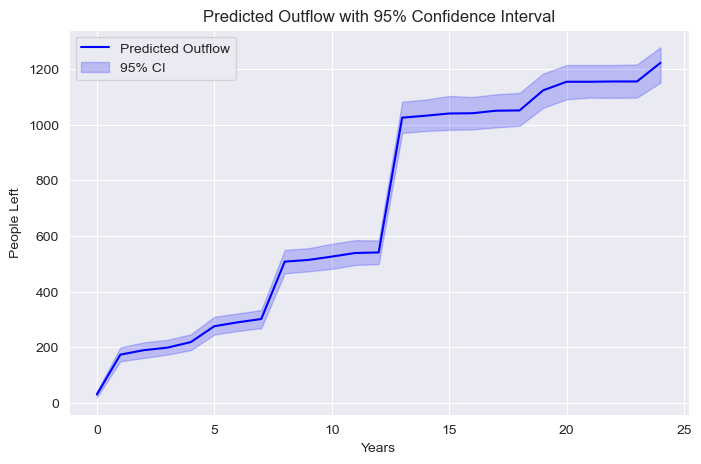

In [84]:
years = range(0, 25)
people_left = []
ci_lower = []
ci_upper = []

# Number of bootstrap resamples
n_bootstraps = 1000

# Extract survival probabilities at each year
for time_point in years:
    survival_at_time = []

    for survival_function in survival_predictions:
        survival_at_time.append(survival_function(time_point))

    survival_at_time = pd.Series(survival_at_time)
    threshold = 0.5

    # Compute the number of people still in the company
    still_in_company = (survival_at_time > threshold).sum()
    proportion_still_in_company = still_in_company / len(survival_at_time)

    # Total population
    total_population = len(X)

    # Predicted number of people who left the company
    predicted_people_left = total_population - still_in_company
    people_left.append(predicted_people_left)

    # Bootstrap resampling for CI
    bootstrap_samples = []
    for _ in range(n_bootstraps):
        sample = survival_at_time.sample(frac=1, replace=True)
        still_in_company_boot = (sample > threshold).sum()
        predicted_people_left_boot = total_population - still_in_company_boot
        bootstrap_samples.append(predicted_people_left_boot)

    # Compute 95% Confidence Interval
    ci_lower.append(np.percentile(bootstrap_samples, 2.5))
    ci_upper.append(np.percentile(bootstrap_samples, 97.5))

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(years, people_left, label="Predicted Outflow", color="blue")
plt.fill_between(years, ci_lower, ci_upper, color="blue", alpha=0.2, label="95% CI")
plt.xlabel("Years")
plt.ylabel("People Left")
plt.title("Predicted Outflow with 95% Confidence Interval")
plt.legend()
plt.show()

Tot slot heb ik voor de API het model nodig als een .pkl.

In [19]:
joblib.dump(rsf, "rsf_model.pkl")

['rsf_model.pkl']